# 機械学習をPythonで実践する-13　～ XGBoost, LightGBM ～
XGBoost(eXtreme Gradient Boosting)やLightGBM(Light Gradient Boosting Machine)を使ってみる。  

参考:  
https://datawokagaku.com/xgboost/  
https://datawokagaku.com/lightgbm/

In [92]:
%load_ext autoreload
%autoreload 2
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize, OrdinalEncoder
# import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,LeaveOneOut, cross_val_score, KFold, RepeatedKFold,StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names,roc_auc_score
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from sklearn import tree
import lightgbm as lgb
from catboost import CatBoostClassifier

%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ○ XGBoost(分類)
pipでxgboostをインストールする必要あり。  
xgboostライブラリからXGBClassifierをインポートして分類を行う。  
基本的な使い方はscikit-learnの各モデルと同じ。インスタンス生成してfitで学習する。  
* 分類器XGBClassifier()インスタンス生成時のパラメータは下記。  
  * n_estimators : ブースティングの回数(=学習する決定木の数)．デフォルトは100．
  * learning_rate : shrinkageのη．デフォルトは0.3。
  * max_depth : 決定木の最高の深さ．デフォルトは6
  * eval_metric : ブースティング時の各イテレーション時に使う評価指標(特に後述するearly stoppingに使用).   
    sklearn.metricsのメソッドを渡すか，自作してもOK．デフォルトは 'logloss'
  * early_stopping_rounds : early stoppingする際の，最低限ブースティングのイテレーションをする回数  
  　※early stoppingとは、ブースティングのイテレーション時に評価指標がそれ以上上がらなくなったら自動で学習をやめてくれること。  
  * importance_type: 目的変数に対する特徴量の寄与度の指標。デフォルトだと分岐に現れる特徴量の出現頻度(weight)だが、'total_gain'（損失の減少度）が適切。  
    <br></br>
* .fit(X, y)のパラメタ
  * eval_set: 各イテレーション毎のearly stopping判定に使用したいデータ。タプルのリストで指定。 　例: [(X_val, y_val)]



In [2]:
# xgboostをインストール。scikit-learnには入っていない。
%pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# xgboostをインポート
from xgboost import XGBClassifier
import xgboost as xgb

In [23]:
# polarsでタイタニックデータを読み込み
df = pl.from_pandas(sns.load_dataset('titanic'))

# 欠損値は落とさなくてよい
#df = df.drop_nulls()

# 学習データ、目的変数を定義
X = df.drop(['survived', 'alive'])
y = df.get_column('survived')

# カテゴリ変数のカラム名をリスト化
category_cols = X.select(pl.col([pl.Utf8, pl.Categorical, pl.Boolean])).columns

# ラベルエンコーディング（LabelEncoderではなく、OrdinalEncoderを使う）
oe = OrdinalEncoder()
# pandasで返ってくるように指定。polarsは指定できない模様
oe.set_output(transform='pandas')
# カテゴリ変数をエンコーディング。polars.DFはそのまま入れられないのでpandasに変換する。
X = X.with_columns( pl.from_pandas(oe.fit_transform(X.select(category_cols).to_pandas())) )

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X.to_pandas(), y.to_pandas(), test_size=0.3, random_state=0)

<b>★重要  
XGBoostは欠損値に対処するアルゴリズムが組み込まれているため、欠損値（NaN）をdropする必要はなく、  
欠損値があるデータをそのままモデルに学習させることができる。</b>  
欠損値に別途値を代入してからXGBoostを学習させてもよいが、XGBoostを使う場合は欠損値対応はせずに、  
そのまま学習させることが多い。もし、欠損値のデータをdropすると学習データが減ってしまい一般的に精度が下がる。  

In [20]:
df['survived'].value_counts()

survived,counts
i64,u32
0,549
1,342


死者の方が多い。

In [25]:
# XGBoostで学習。
model = XGBClassifier(early_stopping_rounds=10, 
                      learning_rate=0.01, 
                      eval_metric='auc',
                      importance_type='total_gain',
                      random_state=0)#, alpha=5)
# .fitのeval_setに(X,y)を渡すと、ブースティング時の各イテレーションごとにこのデータセットで評価(今回はauc)してくれる。
# この評価とはearly stoppingの判定基準のこと。
# 今回は本来のテストデータを検証データに使用。検証データに過学習気味になるので別途CVで汎化性能を確かめた方が良い。
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.86568
[1]	validation_0-auc:0.86533
[2]	validation_0-auc:0.87488
[3]	validation_0-auc:0.87500
[4]	validation_0-auc:0.87488
[5]	validation_0-auc:0.87488
[6]	validation_0-auc:0.87506
[7]	validation_0-auc:0.87452
[8]	validation_0-auc:0.87512
[9]	validation_0-auc:0.87506
[10]	validation_0-auc:0.87500
[11]	validation_0-auc:0.87506
[12]	validation_0-auc:0.87506
[13]	validation_0-auc:0.87506
[14]	validation_0-auc:0.87506
[15]	validation_0-auc:0.87506
[16]	validation_0-auc:0.87506
[17]	validation_0-auc:0.87518
[18]	validation_0-auc:0.87518
[19]	validation_0-auc:0.87530
[20]	validation_0-auc:0.87536
[21]	validation_0-auc:0.87548
[22]	validation_0-auc:0.87464
[23]	validation_0-auc:0.87476
[24]	validation_0-auc:0.87476
[25]	validation_0-auc:0.87476
[26]	validation_0-auc:0.87449
[27]	validation_0-auc:0.87449
[28]	validation_0-auc:0.87443
[29]	validation_0-auc:0.87432
[30]	validation_0-auc:0.87506
[31]	validation_0-auc:0.87554
[32]	validation_0-auc:0.87488
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None,
              importance_type='total_gain', interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=0, ...)

XGBoostの場合、.fitはモデル自体も返してくる。  
本来100回イテレーションを行うはずだが、[35]回目にaucが最小になっているので、  
early-stoppingにより、45回目で学習を終了する。

In [27]:
# 最終的なaucを確認
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1])

0.8761904761904763

上記の予測結果はテストデータをearly stoppingに使った結果のため、  
テストデータに寄せた結果になっている。そのため、実務ではこういったことは厳禁。  
学習データをholdoutするなり、k-fold CVによって精度をきちんと評価すること。

In [56]:
# k-fold CVしてみる
from xgboost import cv
data_dmatrix = xgb.DMatrix(data=X.to_pandas(), label=y.to_pandas())

params = {"objective":"binary:logistic",'learning_rate': 0.01}
                #'max_depth': 5, 'alpha': 5}

# xgboostのcvメソッドでk-fold CV可能
xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=5,
                     early_stopping_rounds=10, metrics="auc", as_pandas=True)

In [57]:
xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.897667,0.005994,0.855386,0.016718
1,0.897812,0.006277,0.857253,0.015811
2,0.897724,0.006005,0.867724,0.023506
3,0.898222,0.006048,0.860781,0.016590
4,0.900407,0.004793,0.862685,0.017822
5,0.900705,0.004881,0.862465,0.017588
6,0.900711,0.004912,0.862915,0.017642
7,0.900726,0.004879,0.862577,0.017313
8,0.900708,0.004864,0.862813,0.017399
9,0.902551,0.002948,0.863767,0.019090


test-auc-meanを見る限り、学習データに過学習気味になっているかもしれない。  

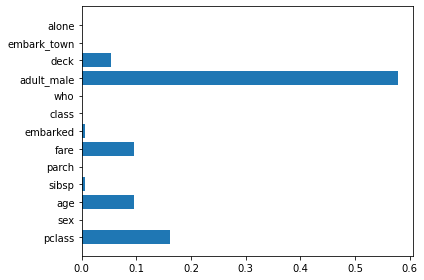

In [66]:
# 特徴量の重要度を表示
plt.barh(X.columns, model.feature_importances_)
plt.tight_layout()

In [62]:
# xgbのcvメソッドを使わない場合のk-Fold CV。Staratifiedすることでfoldごとに含まれるクラスの割合を等しくした状態でCVできる。
# 各モデルの学習結果を詳細に見たいときはこっちの方が良いかも。
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
auc_list = []
class_ratio = {}
model_cv =  XGBClassifier(early_stopping_rounds=10, learning_rate=0.01, eval_metric='auc')
X_pd = X.to_pandas()
y_pd = y.to_pandas()

for train_index, val_index in kf.split(X_pd ,y_pd):
    X_train, X_val = X_pd.iloc[train_index], X_pd.iloc[val_index]
    y_train, y_val = y_pd.iloc[train_index], y_pd.iloc[val_index]
    
    # モデル学習
    eval_set = [(X_val, y_val)]
    model_cv.fit(X_train, y_train, eval_set=eval_set, verbose=True)
    # テストデータに対する予測値算出
    y_pred = model_cv.predict_proba(X_val)
    
    # auc
    auc = roc_auc_score(y_val, y_pred[:, 1])
    auc_list.append(auc)

    # # logloss
    # logloss = log_loss(y_test, y_pred)
    # logloss_list.append(logloss)

[0]	validation_0-auc:0.87365
[1]	validation_0-auc:0.87358
[2]	validation_0-auc:0.87319
[3]	validation_0-auc:0.87358
[4]	validation_0-auc:0.87319
[5]	validation_0-auc:0.87826
[6]	validation_0-auc:0.87826
[7]	validation_0-auc:0.87866
[8]	validation_0-auc:0.87846
[9]	validation_0-auc:0.87846
[10]	validation_0-auc:0.88004
[11]	validation_0-auc:0.88057
[12]	validation_0-auc:0.88024
[13]	validation_0-auc:0.88050
[14]	validation_0-auc:0.88050
[15]	validation_0-auc:0.88050
[16]	validation_0-auc:0.88011
[17]	validation_0-auc:0.88011
[18]	validation_0-auc:0.88037
[19]	validation_0-auc:0.88011
[20]	validation_0-auc:0.88037
[0]	validation_0-auc:0.88102
[1]	validation_0-auc:0.88035
[2]	validation_0-auc:0.87901
[3]	validation_0-auc:0.88035
[4]	validation_0-auc:0.87981
[5]	validation_0-auc:0.87901
[6]	validation_0-auc:0.88035
[7]	validation_0-auc:0.87941
[8]	validation_0-auc:0.87888
[9]	validation_0-auc:0.87848
[10]	validation_0-auc:0.87821
[0]	validation_0-auc:0.84439
[1]	validation_0-auc:0.85234
[2

In [63]:
auc_list

[0.8805665349143611,
 0.8810160427807486,
 0.8645721925133689,
 0.8695187165775401,
 0.801888046802287]

In [51]:
np.mean(auc_list)

0.8595123067176612

xgbのcvメソッドの結果と概ね同じ。こっちの方が計算量は多いが、わかりやすいかも。

XGBoostの中で使われた決定木は.plot_treeで描画できる。  
設定がめんどくさそうなので一旦保留。

In [59]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 2.4 MB/s eta 0:00:00


In [65]:
# import xgboost
# xgboost.plot_tree(model, num_trees=0)

## ○LightGBM

scikit-learnにはないので、pipでインストールする必要あり。  
分類の場合はLGBMClassifier、回帰の場合はLGBMRegressorを使う。  
基本的に他のScikit-learnのクラスと使い方は同じ。  
今回使用するLGBMClassifierでよく使うパラメタは下記。  
* n_estimators : ブースティングの回数(=学習する決定木の数)．デフォルトは100．
* boosting_type : ブースティングアルゴリズムを以下から選択．デフォルトは 'gbdt'
    * 'gbdt' , 従来の Gradient Boosting Decision Tree.
    * 'dart' , Dropouts meet Multiple Additive Regression Trees.
      * 深層学習のNNでよく使われるDARTをGBDTに応用したもの。最終的な予測に使う弱学習器を減らし、過学習を防ぐ。  
    * 'goss' , Gradient-based One-Side Sampling.　  
      * 最も早いので今回はこれを使用
    * 'rf' , Random Forest.’
* learning_rate : shrinkageのη．デフォルトは0.1
* max_depth : 決定木の最大の深さ．デフォルトではfull treeまで学習してしまうので，何か値を入れておくとよい。
* random_state : 乱数のseed

In [1]:
%pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2 -> 23.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [77]:
# polarsでタイタニックデータを読み込み
df = pl.from_pandas(sns.load_dataset('titanic'))

# 欠損値は落とさなくてよい
#df = df.drop_nulls()

# 学習データ、目的変数を定義
X = df.drop(['survived', 'alive'])
y = df.get_column('survived')

# カテゴリ変数のカラム名をリスト化
category_cols = X.select(pl.col([pl.Utf8, pl.Categorical, pl.Boolean])).columns

# ラベルエンコーディング（LabelEncoderではなく、OrdinalEncoderを使う）
oe = OrdinalEncoder()
# pandasで返ってくるように指定。polarsは指定できない模様
oe.set_output(transform='pandas')
# カテゴリ変数をエンコーディング。polars.DFはそのまま入れられないのでpandasに変換する。
X = X.with_columns( pl.from_pandas(oe.fit_transform(X.select(category_cols).to_pandas())) )

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X.to_pandas(), y.to_pandas(), test_size=0.3, random_state=0)

In [78]:
# モデル生成
model_lgb = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

.fit()、すなわち学習の際によく使う引数は下記。  
early stoppingをするには callbacks 引数を使う。  
lgb.early_stopping() と lgb.log_evaluation() （logloss）をリストにして callbacks 引数に入れてあげればOK。  
lgb.log_evaluation() を callbacks に入れることで各イテレーション時に評価指標を出力してくれる。
* eval_set : (X, y)のリストで，これを渡すと，ブースティング時の各イテレーションごとにこのデータセットを使って評価してくれる．
* callbacks  : 各イテレーションの際に実行するcallback関数のリスト(early stopping時に使用)

In [80]:
# 学習。ここではテストデータを検証データとして評価指標にする。（本当はやっちゃだめ）
eval_set = [(X_test, y_test)]
callbacks = [lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation()]
model_lgb.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

[1]	valid_0's binary_logloss: 0.617633
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.583135
[3]	valid_0's binary_logloss: 0.554693
[4]	valid_0's binary_logloss: 0.531959
[5]	valid_0's binary_logloss: 0.513231
[6]	valid_0's binary_logloss: 0.496924
[7]	valid_0's binary_logloss: 0.483944
[8]	valid_0's binary_logloss: 0.472108
[9]	valid_0's binary_logloss: 0.462553
[10]	valid_0's binary_logloss: 0.455246
[11]	valid_0's binary_logloss: 0.448275
[12]	valid_0's binary_logloss: 0.443234
[13]	valid_0's binary_logloss: 0.439964
[14]	valid_0's binary_logloss: 0.435393
[15]	valid_0's binary_logloss: 0.432956
[16]	valid_0's binary_logloss: 0.43035
[17]	valid_0's binary_logloss: 0.427281
[18]	valid_0's binary_logloss: 0.425027
[19]	valid_0's binary_logloss: 0.426526
[20]	valid_0's binary_logloss: 0.421652
[21]	valid_0's binary_logloss: 0.419693
[22]	valid_0's binary_logloss: 0.417307
[23]	valid_0's binary_logloss: 0.411956
[24]	valid_0's binary_logloss

LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

60回目でloglossが最小になったが、early_stopping=10なので、  
最低でもそこから10回は続いている。  
(要はあるイテレーションの結果から10回下がらなければ学習を打ち切っている。)

In [82]:
# ベストの結果を表示
model_lgb.best_iteration_, model_lgb.best_score_

(60,
 defaultdict(collections.OrderedDict,
             {'valid_0': OrderedDict([('binary_logloss',
                            0.39596839431963937)])}))

In [86]:
y_pred_proba = model_lgb.predict_proba(X_test)
y_pred_proba[:10]

array([[0.76276568, 0.23723432],
       [0.92936949, 0.07063051],
       [0.90395982, 0.09604018],
       [0.04179378, 0.95820622],
       [0.43211735, 0.56788265],
       [0.7641032 , 0.2358968 ],
       [0.06449641, 0.93550359],
       [0.06500437, 0.93499563],
       [0.51365981, 0.48634019],
       [0.22319417, 0.77680583]])

In [84]:
log_loss(y_test, y_pred_proba)

0.39596839431963937

In [87]:
roc_auc_score(y_test, y_pred_proba[:, 1])

0.8816964285714287

ほぼ同じ条件なので、AUCスコア的にはXGBoostよりもちょっと精度良さそう。

In [89]:
y_pred = model_lgb.predict(X_test)
accuracy_score(y_test, y_pred)

0.8208955223880597

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

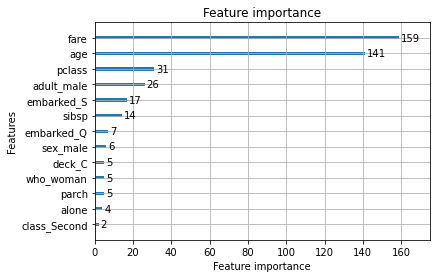

In [26]:
# 特徴量の重要度を確認
lgb.plot_importance(model)

デフォルトの状態ではモデルでその特徴量が使用された回数を重要度として出力してしまう。  
importance_type='gain'とすることで、特徴量の重要度を'gain'（損失関数の減少への寄与）で確認することができる。  
こちらの方が重要度の指標としては適切かもしれない。

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

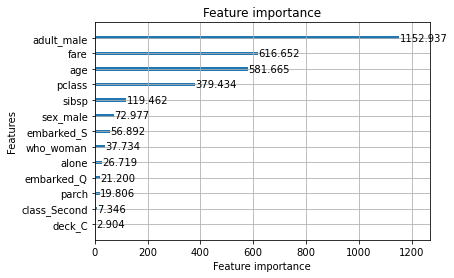

In [31]:
lgb.plot_importance(model, importance_type='gain')

1位の特徴量に関してはxgboostと同様になった。

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

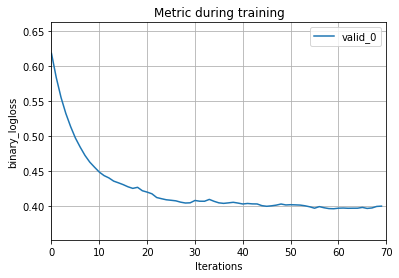

In [90]:
# 学習曲線を描画
lgb.plot_metric(model_lgb)

## ○ CatBoost

In [91]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 4.1 MB/s eta 0:00:0000:0100:01


In [98]:
# polarsでタイタニックデータを読み込み
df = pl.from_pandas(sns.load_dataset('titanic'))

# CatBoostでは欠損値は落とすか埋める必要がある。
df = df.drop_nulls()

# 学習データ、目的変数を定義
X = df.drop(['survived', 'alive'])
y = df.get_column('survived')

# カテゴリ変数のカラム名をリスト化
category_cols = X.select(pl.col([pl.Utf8, pl.Categorical, pl.Boolean])).columns

# CatBoostではエンコーディングする必要なし
# ラベルエンコーディング（LabelEncoderではなく、OrdinalEncoderを使う）
# oe = OrdinalEncoder()
# # pandasで返ってくるように指定。polarsは指定できない模様
# oe.set_output(transform='pandas')
# # カテゴリ変数をエンコーディング。polars.DFはそのまま入れられないのでpandasに変換する。
# X = X.with_columns( pl.from_pandas(oe.fit_transform(X.select(category_cols).to_pandas())) )

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X.to_pandas(), y.to_pandas(), test_size=0.3, random_state=0)

CatBoostではカテゴリ変数をエンコーディングする必要はないが、  
欠損値はdropするか埋める必要がある。

In [99]:
category_cols

['sex',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alone']

In [107]:
# 学習
model_cb = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=category_cols)
eval_set = [(X_test, y_test)]
model_cb.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True)

0:	learn: 0.6885366	test: 0.6868442	best: 0.6868442 (0)	total: 2.13ms	remaining: 2.12s
1:	learn: 0.6814490	test: 0.6793775	best: 0.6793775 (1)	total: 5.97ms	remaining: 2.98s
2:	learn: 0.6760508	test: 0.6726860	best: 0.6726860 (2)	total: 12.4ms	remaining: 4.13s
3:	learn: 0.6712676	test: 0.6671826	best: 0.6671826 (3)	total: 16.4ms	remaining: 4.08s
4:	learn: 0.6653107	test: 0.6593995	best: 0.6593995 (4)	total: 20.1ms	remaining: 4s
5:	learn: 0.6598695	test: 0.6518437	best: 0.6518437 (5)	total: 23.1ms	remaining: 3.83s
6:	learn: 0.6558456	test: 0.6467404	best: 0.6467404 (6)	total: 27.6ms	remaining: 3.92s
7:	learn: 0.6515199	test: 0.6413944	best: 0.6413944 (7)	total: 32ms	remaining: 3.97s
8:	learn: 0.6471426	test: 0.6356173	best: 0.6356173 (8)	total: 36.2ms	remaining: 3.99s
9:	learn: 0.6431772	test: 0.6310513	best: 0.6310513 (9)	total: 41ms	remaining: 4.06s
10:	learn: 0.6392733	test: 0.6260433	best: 0.6260433 (10)	total: 43.8ms	remaining: 3.94s
11:	learn: 0.6349835	test: 0.6211657	best: 0.621

In [108]:
y_pred_cb = model_cb.predict_proba(X_test)
roc_auc_score(y_test, y_pred_cb[:,1])

0.8942307692307693

In [109]:
model_cb.plot_tree(tree_idx=0)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH